<a href="https://colab.research.google.com/github/dalexa10/Python_Data_Science/blob/main/Materials_Analysis/PlotAlignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook plots the band alignment of materials using the data from Materials Project.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import bisect
import itertools
import copy
import operator
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0
csfont = {'fontname':'Times New Roman'}
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In the next cell, specify the MPIDs for he desired materials.  Order is not important, they will be sorted automatically.

In [15]:
# IDsToPlot=[886,554278,352,10390,19342,5238,4840,3839,19833,22386,22736,22811,546794,19921,856,570136,22883,1143,2920,
#           661,672,804,22205,7631,2133,2172,1550,2624,2691,406,2534,2490,1156,20305,20012,10695,1190,2176,361,1132,
#           23251,1265,715434,32,149]
IDsToPlot=[886,554278,352,10390,19342,5238,4840,3839,19833,22386]

The next slide is the main section.

<ipython-input-16-6bcea8e521fa>:4: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  MPData=np.genfromtxt('/content/drive/My Drive/Colab Notebooks/CNData_DensityEHullNAt_CompENeg_GapCorrCNL0.txt',dtype=None) #MP data with gap correction, CNL at 0
<ipython-input-16-6bcea8e521fa>:23: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  Formulas=np.genfromtxt('/content/drive/My Drive//Colab Notebooks/ChemComps.txt',dtype=None) #Only need chemical formulas, not separated names


[886, -3.2988920000000004, 0.32089199999999973, b"b'Ga2O3'", 12]
[554278, -1.3952142856999998, 1.7762142856999992, b"b'TiO2'", 12]
[352, -2.88, 3.0199999999999996, b"b'HfO2'", 14]
[10390, -1.2249980000000007, 1.340998, b"b'Ta2O5'", 15]
[19342, -1.734442, 0.9754420000000001, b"b'WO3'", 60]
[5238, -1.3743440000000007, 0.49034399999999856, b"b'GaCuS2'", 122]
[4840, -1.0158080000000003, -0.046192000000000455, b"b'GaCuSe2'", 122]
[3839, -0.7038219999999997, 0.483822, b"b'GaCuTe2'", 122]
[19833, -1.362924, 0.05692399999999953, b"b'InAgS2'", 122]
[22386, -0.7868099999999996, 0.2138100000000005, b"b'InAgTe2'", 122]


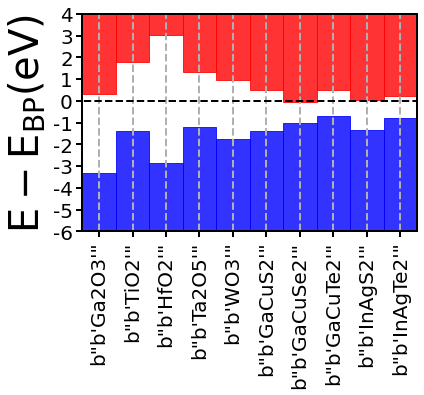

In [16]:
#ExpDat=np.genfromtxt('UserCNLData_Exp.txt')
ExpDat=[]
ExpCNL=[]
MPData=np.genfromtxt('/content/drive/My Drive/Colab Notebooks/CNData_DensityEHullNAt_CompENeg_GapCorrCNL0.txt',dtype=None) #MP data with gap correction, CNL at 0
AllIDs=[]
AllCNLs=[]
AllGaps=[]
AllVBMs=[]

for i in range(0,len(MPData)):
    AllIDs.append(MPData[i][0])
    AllCNLs.append(MPData[i][1])
    AllGaps.append(MPData[i][2])
    AllVBMs.append(MPData[i][4])
    
FilteredIDs=np.array([i[0] for i in MPData])
FilteredDataIndices=[np.where(FilteredIDs==a)[0] for a in IDsToPlot]
FilteredDataIndices=[item for sublist in FilteredDataIndices for item in sublist]

#Import list of descriptors for sym group and list of chemical formulas
#both these files have the same indexing
DescriptorsData=np.genfromtxt('/content/drive/My Drive//Colab Notebooks/Descriptors.txt',dtype=None)
Formulas=np.genfromtxt('/content/drive/My Drive//Colab Notebooks/ChemComps.txt',dtype=None) #Only need chemical formulas, not separated names
allIDs=np.array([i[0] for i in DescriptorsData])
FullDataIndices=[np.where(allIDs==a)[0] for a in IDsToPlot]
FullDataIndices=[x for sublist in FullDataIndices for x in sublist]

#Collect MPID,VBM,CBM,Formula,SymGroup#
AllData=[[i,MPData[b][4],MPData[b][5],MPData[b][7],DescriptorsData[c][4]] for (i,b,c) in zip(IDsToPlot,FilteredDataIndices,FullDataIndices)]
for item in AllData:
    print(item)
AllData.sort(key = operator.itemgetter(4, 3)) #Sort by sym group number then by name
#for i in range(0,len(AllData)):
#    print AllData[i]
MPVBM=[AllData[a][1] for a in range(0,len(AllData))]
MPCBM=[AllData[a][2] for a in range(0,len(AllData))]

#Put user data into arrays and shifts CNL for comparison with MP
for i in range(0,len(AllData)):   
    if AllData[i][0] in ExpDat:
        ind1=np.where(ExpDat==AllData[i][0])[0][0]
        ExpCNL.append(ExpDat[ind1][1]+AllData[i][1])
        #print(AllData[i][0],AllData[i][3])
    else:
        ExpCNL.append(1000.0)

#print CitrineErr      
lowerVBM=[-1000]*len(AllData) #For bar plotting purposes
upperCBM=[1000]*len(AllData)

#hfont = {'fontname':'Times New Roman'}
x=np.arange(len(AllData))
xticks=[]
y=np.arange(-10,10,1)
yticks=np.arange(-10,10,1)
for i in np.arange(0,len(AllData)):
    xticks.append(AllData[i][3])
# print(xticks)
plt.xticks(rotation=90)
plt.bar(x,lowerVBM,1.0,bottom=MPVBM,color='b',alpha=0.8,align='center',edgecolor='b',label='Materials Project Bands')
plt.bar(x,upperCBM,1.0,bottom=MPCBM,color='r',alpha=0.8,edgecolor='r',align='center')
plt.plot(x,ExpCNL,linestyle='None',marker='h',color='m',markersize=12,label=r'E$_{CN,Exp}$')

ml = AutoMinorLocator(4)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=6)
plt.tick_params(which='minor', length=4)
plt.plot([-10,max(x)+10],[0,0],'--k',linewidth=2.0)
plt.xticks(x, xticks, fontsize=20,**csfont)
plt.yticks(y,yticks,fontsize=28,**csfont)
plt.gca().xaxis.grid(True,linestyle='--',linewidth=2.0)
plt.axis([-.5, len(AllData)-.5, -6,4])
plt.ylabel(r"$\rm{E-E_\mathrm{BP} (eV)}$",fontsize=40,**csfont)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.gca().axes().yaxis.set_minor_locator(ml)
plt.show() 
